In [ ]:
!pip install ppscore
!pip install feature_selector
!pip install catboost
!pip install sweetviz
!pip install --upgrade pandas
!pip install --upgrade numpy
!pip install -U scikit-learn==0.21
!pip install scikit-optimize


In [8]:
import numpy as np
import pandas as pd
from mlxtend.feature_selection import ColumnSelector
import ppscore as pps
from time import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold, cross_val_score
import seaborn as sns
from sklearn.metrics import mean_squared_error 
from google.colab import files
from sklearn.model_selection import KFold, train_test_split,StratifiedKFold
from catboost import CatBoostRegressor
from lightgbm import plot_importance,LGBMRegressor
import warnings
import sklearn as sk
from scipy import stats
import numpy as np
import re
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import ElasticNet, Lasso
import warnings
from google.colab import files
import featuretools as ft
import featuretools.variable_types as vtypes
from google.colab import drive

warnings.filterwarnings('ignore')
drive.mount("/GD")


Drive already mounted at /GD; to attempt to forcibly remount, call drive.mount("/GD", force_remount=True).


In [ ]:
###CHANGE THE ADRESS HERE############################
df_train = pd.read_csv("/GD/My Drive/power/Train.csv")
df_test = pd.read_csv("/GD/My Drive/power/Test.csv")
#####################################################

In [27]:
#IDENTIFYING DUPLICATES IN THE DATASET
print('No. of duplicates in train: '+str(len(df_train)-len(df_train.drop(['PE'],axis=1).drop_duplicates())))
print('No. of duplicates in test: '+str(len(df_test)-len(df_test.drop_duplicates())))

No. of duplicates in train: 3110
No. of duplicates in test: 28750


In [2]:

#WITH THESE MANY DUPLICATES IN TRAIN AND TEST, CHANCES ARE SOME OF THEM WILL BE EXACTLY SAME.
#SO WE ARE JUST MANUALLY IMPUTING THOSE VALUES BY TAKING MEAN FROM TRAIN AND WILL PREDICT FOR THE REST OF THE DATA
df_test['key']=df_test[['AT', 'V', 'AP', 'RH']].apply(lambda x: '_'.join(x.astype('str')), axis = 1)
df_train['key']=df_train[['AT', 'V', 'AP', 'RH']].apply(lambda x: '_'.join(x.astype('str')), axis = 1)
df=pd.DataFrame(df_train.groupby(['key'],as_index=False)['PE'].mean())
df=df.reset_index()
encode = dict(zip(df.key, df.PE))
df_test['PE']=df_test.key.map(encode)
#THERE ARE ABOUT 15-20K DUPLICATES IN TEST WHICH EXACTLY RESEMBLE THOSE IN TRAIN. 
df_test2=df_test[np.isnan(df_test.PE)].drop(['PE'],axis=1)
df_train2=df_train.drop(['PE'],axis=1).drop_duplicates()
encode = dict(zip(df_train.key, df_train.PE))
df_train2['PE']=df_train2.key.map(encode)
df_train2.drop(['key'],axis=1,inplace=True)
df_train.drop(['key'],axis=1,inplace=True)
df_test2['is_what']='test'
df_train2['is_what']='train'
#COMBINING TRAING AND TEST FOR AUTOMATED FEATURETOOLS
feats=df_train2.drop(['PE'],axis=1).append(df_test2.drop(['key'],axis=1))
Y=df_train2['PE']


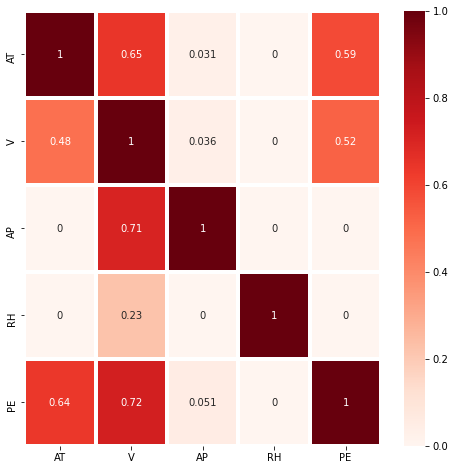

In [6]:
#Tree based relationships
df=pps.matrix(df_train2.drop(['is_what'],axis=1))
fig, ax = plt.subplots(figsize=(8,8)) 
# sns.set(font_scale=1.3)
g=sns.heatmap(df, vmin=0, vmax=1, cmap="Reds", linewidths=3, annot=True,ax=ax,annot_kws={"fontsize":10})

#AT and V seems to be the most important in explainaing target

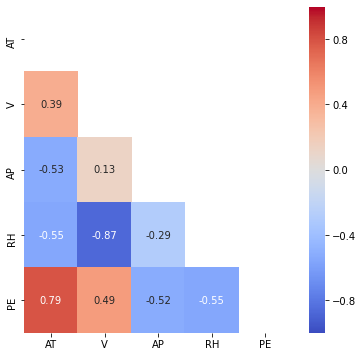

In [9]:
corr=df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
plt.figure(figsize=(6,6))
sns.heatmap(corr,vmin=-1,cmap='coolwarm',annot=True,mask=mask);
#no collinearity found. linear models will perform well here but i sadly didn have the time to explore them
#FOR IMPROVEMENT I STRONGLY SUGGEST CREATING A TARGET MIMIC COLUMN BASED ON KFOLDED PREDICTIONS WITH A LINEAR MODEL 

<AxesSubplot:>

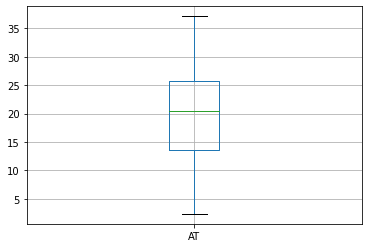

In [11]:
df_train2.boxplot(column='AT')

<AxesSubplot:>

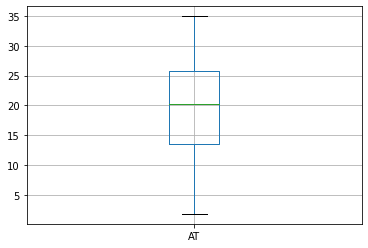

In [12]:
df_test2.drop_duplicates().boxplot(column='AT')

array([[<AxesSubplot:title={'center':'PE'}>]], dtype=object)

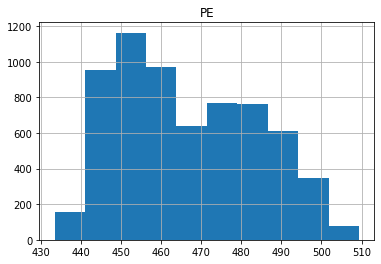

In [13]:
df_train2.hist(column='PE')
#no need to normalize target
#similar to bimodal distribution 

In [3]:
#AUTOMATED FEATURE ENGINEERING, WITH SO LESS FEATURES PRESENT AND MY LACK OF DOMAIN KNOWLEDGE ITS BETTER TO USE THIS . 
#REMEMBER THIS IS NO REPLACEMENT FOR PEOPLE WHO ACTUALLY KNOW THE DOMAIN AND CREATE RELEVANT FEATURES RELATED TO THERMODYNAMICS
#VERY HIGH AMOUNT OF TIME NEEDED FOR FEATURE SELECTION AFTER CREATING THESE MANY FEATURES TO IDENTIFY THE BEST. NOT FEASIBLE FOR LARGER DATASETS
df2=feats
es = ft.EntitySet(id = 'power')
variable_types = { 'is_what': vtypes.Categorical
                  }
es.entity_from_dataframe(entity_id = 'data', dataframe = df2, 
                         make_index = True, index = 'index',variable_types=variable_types)
feature_matrix, feature_list = ft.dfs(entityset = es, target_entity = 'data',
                                      trans_primitives = ['percentile','divide','multiply'],max_depth=3
                                      )
main2=feature_matrix
TEST=main2[main2['is_what']=='test'].drop(['is_what'],axis=1)
TRAIN=main2[main2['is_what']=='train'].drop(['is_what'],axis=1)

In [9]:
lgbmcols=['AP / V * PERCENTILE(V) / V', 'V', 'PERCENTILE(AP) * PERCENTILE(V)',
       'AT * RH', 'AT', 'PERCENTILE(AP) / RH * PERCENTILE(V) / AP',
       'PERCENTILE(AP) / V', 'V / PERCENTILE(V)']
catcols=['AT', 'AP / V * PERCENTILE(V) / V', 'V', 'V / PERCENTILE(V)', 'AT * RH',
       'PERCENTILE(AP) / V * PERCENTILE(V) / V', 'AP / AT * AP / RH',
       'PERCENTILE(AP) / RH * PERCENTILE(V) / AP']
imp_columns=['AP / V * PERCENTILE(V) / V', 'V', 'PERCENTILE(AP) * PERCENTILE(V)',
       'AT * RH', 'AT', 'PERCENTILE(AP) / RH * PERCENTILE(V) / AP',
       'PERCENTILE(AP) / V', 'V / PERCENTILE(V)','AT', 'AP / V * PERCENTILE(V) / V', 'V', 'V / PERCENTILE(V)', 'AT * RH',
       'PERCENTILE(AP) / V * PERCENTILE(V) / V', 'AP / AT * AP / RH',
       'PERCENTILE(AP) / RH * PERCENTILE(V) / AP']
IMP_COLUMNS2=list(set(imp_columns))
TRAIN_FINAL=TRAIN[IMP_COLUMNS2]
TEST_FINAL=TEST[IMP_COLUMNS2]
cb = CatBoostRegressor(bagging_temperature=1.0, verbose=0,
border_count=255,depth=8,iterations=4000,l2_leaf_reg=2,learning_rate=0.05207083574210583,random_strength=1e-09)
lgbm=LGBMRegressor(n_estimators=800,learning_rate=0.1)
stack = StackingCVRegressor(regressors=[cb,lgbm], 
                           meta_regressor=ElasticNet(alpha=0.001, l1_ratio=0.3))

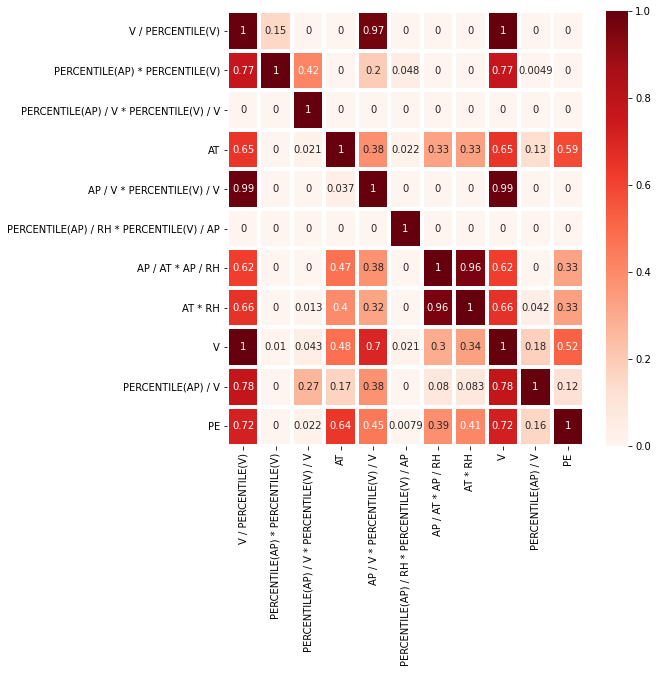

In [6]:
#Tree based relationships
TRAIN_FINAL2=TRAIN_FINAL
TRAIN_FINAL2['PE']=Y.values
df=pps.matrix(TRAIN_FINAL2)
fig, ax = plt.subplots(figsize=(8,8)) 
# sns.set(font_scale=1.3)
g=sns.heatmap(df, vmin=0, vmax=1, cmap="Reds", linewidths=3, annot=True,ax=ax,annot_kws={"fontsize":10})

#we have managed to create few more significant variables with automated feat engineering

In [14]:
TRAIN_FINAL.describe()

,V / PERCENTILE(V),PERCENTILE(AP) * PERCENTILE(V),PERCENTILE(AP) / V * PERCENTILE(V) / V,AT,AP / V * PERCENTILE(V) / V,PERCENTILE(AP) / RH * PERCENTILE(V) / AP,AP / AT * AP / RH,AT * RH,V,PERCENTILE(AP) / V
count,6458.000000,6458.000000,6.458000e+03,6458.000000,6458.000000,6.458000e+03,6458.000000,6458.000000,6458.000000,6458.000000
mean,320.279630,0.219275,7.257078e-05,19.656499,0.151492,3.189050e-06,872.762136,1382.795233,54.350430,0.010393
std,2116.604273,0.160290,4.721430e-05,7.441464,0.047762,2.674294e-06,441.929236,472.728028,12.680831,0.007071
min,76.837349,0.000058,3.400390e-08,2.340000,0.000575,8.762123e-10,382.988552,163.051200,25.360000,0.000007
25%,88.170400,0.082008,3.120300e-05,13.550000,0.147574,1.104172e-06,583.996904,1014.820350,41.760000,0.004336
50%,104.916257,0.196131,6.831122e-05,20.370000,0.171926,2.558165e-06,733.638395,1397.638450,52.540000,0.009410
75%,164.938392,0.321696,1.100254e-04,25.710000,0.176726,4.594432e-06,1017.163547,1748.258700,66.540000,0.015745
max,69163.060000,0.795566,1.897883e-04,37.110000,0.201300,2.539635e-05,6487.229416,2647.989600,81.560000,0.028519


In [15]:
TEST_FINAL.describe()

,V / PERCENTILE(V),PERCENTILE(AP) * PERCENTILE(V),PERCENTILE(AP) / V * PERCENTILE(V) / V,AT,AP / V * PERCENTILE(V) / V,PERCENTILE(AP) / RH * PERCENTILE(V) / AP,AP / AT * AP / RH,AT * RH,V,PERCENTILE(AP) / V
count,15360.000000,15360.000000,1.536000e+04,15360.000000,15360.000000,1.536000e+04,15360.000000,15360.000000,15360.000000,15360.000000
mean,335.142538,0.212629,7.060568e-05,19.663880,0.151050,3.126859e-06,874.043141,1381.797196,54.183174,0.010219
std,2076.531150,0.157593,4.696063e-05,7.450696,0.048540,2.715188e-06,444.320183,474.070757,12.705135,0.007113
min,76.837349,0.000029,1.700195e-08,1.810000,0.000575,3.465746e-10,395.111949,139.315700,25.360000,0.000003
25%,88.843361,0.077865,2.904441e-05,13.487500,0.144662,1.042706e-06,581.046765,1028.506425,41.660000,0.004176
50%,104.935903,0.189823,6.610332e-05,20.290000,0.171914,2.490210e-06,735.026527,1397.706000,51.860000,0.008927
75%,168.306246,0.314732,1.074962e-04,25.720000,0.177158,4.518568e-06,1005.696894,1758.544200,66.490000,0.015377
max,69163.060000,0.798017,1.894867e-04,34.960000,0.201268,2.627043e-05,7569.604046,2590.242400,80.250000,0.028485


In [24]:
i=0
l=[]
setused=TRAIN_FINAL
scores=[]
kfold, scores = KFold(n_splits=5,random_state=True), list()
for train2, test2 in kfold.split(setused,Y):
    x_train, x_test = setused.values[train2], setused.values[test2]
    y_train, y_test = Y.values[train2], Y.values[test2]
    ############################## 
    model = stack
    model.fit(x_train, y_train)
    preds = model.predict(x_test)
    ######################(doesn work with stacking regressor)####
    # feature_importances = pd.DataFrame(model.feature_importances_,
    #                                    index = setused.columns,
    #                                     columns=['importance'])
    # sum=feature_importances.values
    # l.append(sum)
    ##########################3###################################
    score = np.sqrt(mean_squared_error(y_test, preds))
    scores.append(score)
    print(score)
print("Average: ", np.sum(scores)/len(scores))


3.1117806877322494
3.5274959823601693
3.1564091641959364
3.2292650363926434
3.0770726853515717
Average:  3.220404711206514


10

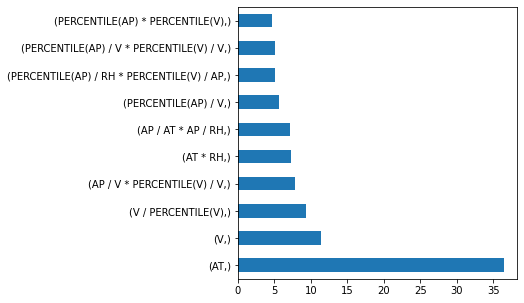

In [22]:
###this averages out the feature importances of each fold to show us on an average which features are doing better####
#selectkbest or simply plotting nlargest may show feature importance from a single fold.
#as trees doesn have a fixed structure to build the trees for reducing entropy the features which are preferred on an average by the trees give better pic
train_set=setused
labels=Y
threshold=0.5
add=0
for item in l:
  add+=item
df_cv=pd.DataFrame(add/len(l),index=train_set.columns,columns=["importance"]).sort_values('importance', ascending=False)
imp_columns=df_cv[df_cv['importance']>threshold].index.tolist()
df_cv=df_cv.reset_index()
feat_imp = pd.Series(df_cv.importance.values, index=df_cv.drop(["importance"], axis=1)).sort_values(axis='index',ascending=False)
X2=setused[imp_columns]
feat_imp.nlargest(10).plot(kind='barh', figsize=(5,5))
len(imp_columns)
#this plot is for catboost only

In [ ]:
#SUBMISSION MODULE
#HERE FIRST THE PREDICTION ON 15K IS DONE AND THEN IT IS ADDED ON TO THE PRE EXISTING TEST SET HAVING SOME OF ITS COMMON VALUES IMPUTED AT BEGINING
model2=stack
filen='submission.xlsx'
X_test = TEST_FINAL
model2.fit(TRAIN_FINAL.values,Y.values)
y_pred =model2.predict(X_test.values)
df_test2['PE']=y_pred
encode2 = dict(zip(df_test2.key, df_test2.PE))
df1=pd.DataFrame()
###THE VALUES WHICH COUDNT BE FOUND EARLIER ARE NOW BEING ADDED BY OUR MODEL######
df1['PE']=df_test['PE'].fillna(df_test['key'].map(encode2))
df1['PE'].to_excel('/GD/My Drive/power/'+str(filen),index=False)
files.download('/GD/My Drive/power/'+str(filen))
